# Question 3

# Task 1

In [5]:
"""
Insert all necessary libraries for question 1 to 4
"""

import os  # Provides a way of using operating system-dependent functionality
import pandas as pd  # Used for data manipulation and analysis
import numpy as np  # Supports large, multi-dimensional arrays and matrices, along with mathematical functions
import matplotlib.pyplot as plt  # Used for creating static, animated, and interactive plots
import seaborn as sns  # Provides a high-level interface for drawing attractive and informative statistical graphics
import matplotlib as mpl  # Base matplotlib interface for working with styles, fonts, etc.
import scipy  # Fundamental package for scientific computing
import scipy.stats as stats  # Contains a large number of probability distributions and statistical functions
from scipy.stats import norm  # Imports the normal distribution object for statistical calculations
from scipy.optimize import minimize  # Uses numerical optimization for functions without closed-form solutions (e.g., YTM)
import statsmodels.api as sm  # Provides classes and functions for statistical models and tests
from statsmodels.formula.api import ols  # Facilitates specifying statistical models using formulas

In [6]:
# Step 1: Load and Preprocess CRSP Data


# Load CRSP dataset
crsp_files = ["crspjan2000dec2010.csv", "crspjan2011dec2021.csv"]

# Read and concatenate CRSP data
crsp_data = [pd.read_csv(file, encoding="ISO-8859-1", delimiter=",", on_bad_lines="skip", engine="python") for file in crsp_files]
crsp_df = pd.concat(crsp_data, ignore_index=True)

# Convert SICCD to numeric, handling errors
crsp_df["SICCD"] = pd.to_numeric(crsp_df["SICCD"], errors="coerce")

# Define SIC code exclusion ranges
excluded_ranges = [(100, 999), (9100, 9729), (9900, 9999)]

def is_excluded(sic):
    if pd.isna(sic):  # Missing values are considered non-classifiable
        return False
    return any(lower <= sic <= upper for lower, upper in excluded_ranges)

# Filter out excluded SIC codes
filtered_crsp_df = crsp_df[~crsp_df["SICCD"].apply(is_excluded)].copy()

# Assign industry classification (first two digits of SIC code)
filtered_crsp_df["Industry"] = filtered_crsp_df["SICCD"].apply(
    lambda x: "Non-Classifiable" if pd.isna(x) else str(int(x))[:2]
)

# Keep relevant columns
filtered_crsp_df = filtered_crsp_df[['date', 'SICCD', 'RET', 'vwretd', 'Industry']]

# Convert date to datetime format
filtered_crsp_df["date"] = pd.to_datetime(filtered_crsp_df["date"], format="%Y%m%d", errors="coerce")

# Convert RET to numeric
filtered_crsp_df["RET"] = pd.to_numeric(filtered_crsp_df["RET"], errors="coerce")

# Drop rows where RET is NaN
filtered_crsp_df = filtered_crsp_df.dropna(subset=["RET"])

# Restrict data to 2006-2018
filtered_crsp_df = filtered_crsp_df[(filtered_crsp_df["date"] >= "2006-01-01") & (filtered_crsp_df["date"] <= "2018-12-31")]

print(f" CRSP Data Date Range: {filtered_crsp_df['date'].min()} to {filtered_crsp_df['date'].max()}")



 CRSP Data Date Range: 2006-01-31 00:00:00 to 2018-12-31 00:00:00


In [8]:
#Confirm working directory
import os
print(os.getcwd())  # Prints the current working directory
print(os.listdir())

C:\Users\josep\Python for Finance\Complete Coursework Questions
['.ipynb_checkpoints', 'BSM169 - FINAL COURSEWORK.ipynb', 'crspjan2000dec2010.csv', 'crspjan2011dec2021.csv', 'datanew.csv', 'day.csv', 'Evaluating Housing Forecasts, Accuracy, Industry Differences, and Links to Financial Markets.ipynb', 'F-F_Momentum_Factor.CSV', 'F-F_Research_Data_Factors.CSV', 'Forecasts.xlsx', 'HStarts Actual.xlsx', 'SPY.csv', 'Untitled.ipynb', 'vwret.csv', 'Yield to Maturity Estimation and Sensitivity Analysis of Coupon Bonds.ipynb']


In [9]:
# Step 2: Compute Industry Portfolios

# Compute equal-weighted portfolio returns for each industry
industry_groups = filtered_crsp_df.groupby(["Industry", "date"])["RET"].mean().reset_index()

# Also compute the number of firms per industry per month
industry_counts = filtered_crsp_df.groupby(["Industry", "date"])["SICCD"].count().reset_index()
industry_counts.rename(columns={"SICCD": "Firm_Count"}, inplace=True)

# Pivot data to have industries as columns
industry_returns = industry_groups.pivot(index="date", columns="Industry", values="RET")
industry_firm_counts = industry_counts.pivot(index="date", columns="Industry", values="Firm_Count")

# Compute an equally weighted index (all industries get equal weight per period)
industry_returns["Equal_Weighted_Index"] = industry_returns.mean(axis=1)

print(f" Industry Returns Data Shape: {industry_returns.shape}")


 Industry Returns Data Shape: (156, 70)


In [13]:
# Step 3: Load and Process Fama-French Data

ff_factors_path = "F-F_Research_Data_Factors.CSV" 


# Read CSV (skip non-numeric header rows)
ff_factors = pd.read_csv(ff_factors_path, skiprows=3, encoding="utf-8", delimiter=",")

# Strip spaces from column names
ff_factors.columns = ff_factors.columns.str.strip()

# Rename columns dynamically (first column is date)
expected_cols = {
    ff_factors.columns[0]: "date",  
    ff_factors.columns[1]: "Mkt-RF",
    ff_factors.columns[2]: "SMB",
    ff_factors.columns[3]: "HML",
    ff_factors.columns[4]: "RF"  
}
ff_factors.rename(columns=expected_cols, inplace=True)

# Convert 'date' to datetime (YYYYMM to end-of-month)
ff_factors["date"] = pd.to_datetime(ff_factors["date"], format="%Y%m", errors="coerce") + pd.offsets.MonthEnd(0)

# Convert factor columns to numeric
for col in ["Mkt-RF", "SMB", "HML", "RF"]:
    ff_factors[col] = pd.to_numeric(ff_factors[col], errors="coerce")

# Restrict Fama-French data to 2006-2018
ff_factors = ff_factors[(ff_factors["date"] >= "2006-01-01") & (ff_factors["date"] <= "2018-12-31")]

print(f" Fama-French Data Date Range: {ff_factors['date'].min()} to {ff_factors['date'].max()}")
print(f" Fama-French Data (First Rows):\n{ff_factors.head()}")

# Step 4: Merge Datasets

merged_data = pd.merge(industry_returns, ff_factors, on="date", how="inner")
print(f" Merged dataset now has {merged_data.shape[0]} rows")

 Fama-French Data Date Range: 2006-01-31 00:00:00 to 2018-12-31 00:00:00
 Fama-French Data (First Rows):
          date  Mkt-RF   SMB   HML    RF
954 2006-01-31    3.04  5.40  1.08  0.35
955 2006-02-28   -0.30 -0.38 -0.34  0.34
956 2006-03-31    1.46  3.44  0.60  0.37
957 2006-04-30    0.73 -1.42  2.34  0.36
958 2006-05-31   -3.57 -2.96  2.41  0.43
 Merged dataset now has 111 rows


In [15]:
# Step 5: Compute Performance Metrics

performance_table = []
for industry in industry_returns.columns:
    if industry not in merged_data.columns or merged_data[industry].isna().all():
        continue  # Skip if data is missing

    avg_ret = merged_data[industry].mean()
    vol = merged_data[industry].std()
    sharpe = avg_ret / vol if vol != 0 else np.nan
    # Compute average number of firms from the firm count pivot table (only if the industry exists there)
    avg_firm_count = industry_firm_counts[industry].mean() if industry in industry_firm_counts.columns else np.nan

    # Compute Beta using CAPM (excess returns over risk-free rate)
    try:
        y = merged_data[industry] - merged_data["RF"]
        X = merged_data["Mkt-RF"]
        X = sm.add_constant(X)
        valid_idx = ~y.isna() & ~X["Mkt-RF"].isna()
        y, X = y[valid_idx], X[valid_idx]
        if len(y) > 1:
            capm_model = sm.OLS(y, X).fit()
            beta = capm_model.params["Mkt-RF"]
        else:
            beta = np.nan
    except Exception as e:
        print(f" Regression failed for {industry}: {e}")
        beta = np.nan

    performance_table.append([industry, avg_ret, vol, beta, sharpe, avg_firm_count])

performance_df = pd.DataFrame(performance_table, columns=["Industry", "Avg Return", "Volatility", "Beta (CAPM)", "Sharpe Ratio", "Avg Firms"])
print(" Performance Summary:\n", performance_df)


 Performance Summary:
                 Industry  Avg Return  Volatility  Beta (CAPM)  Sharpe Ratio  \
0                      0   -0.001110    0.118479     0.010427     -0.009366   
1                     10    0.003334    0.114868     0.018179      0.029023   
2                     12   -0.003477    0.123771     0.017982     -0.028093   
3                     13   -0.003987    0.099969     0.020681     -0.039883   
4                     14   -0.005642    0.095773     0.019583     -0.058908   
..                   ...         ...         ...          ...           ...   
65                    86    0.012223    0.138156     0.017504      0.088472   
66                    87    0.008094    0.063012     0.017132      0.128456   
67                    89    0.003420    0.091814     0.017592      0.037252   
68      Non-Classifiable    0.003136    0.122796     0.018528      0.025537   
69  Equal_Weighted_Index    0.007230    0.060396     0.017415      0.119711   

     Avg Firms  
0     9.343

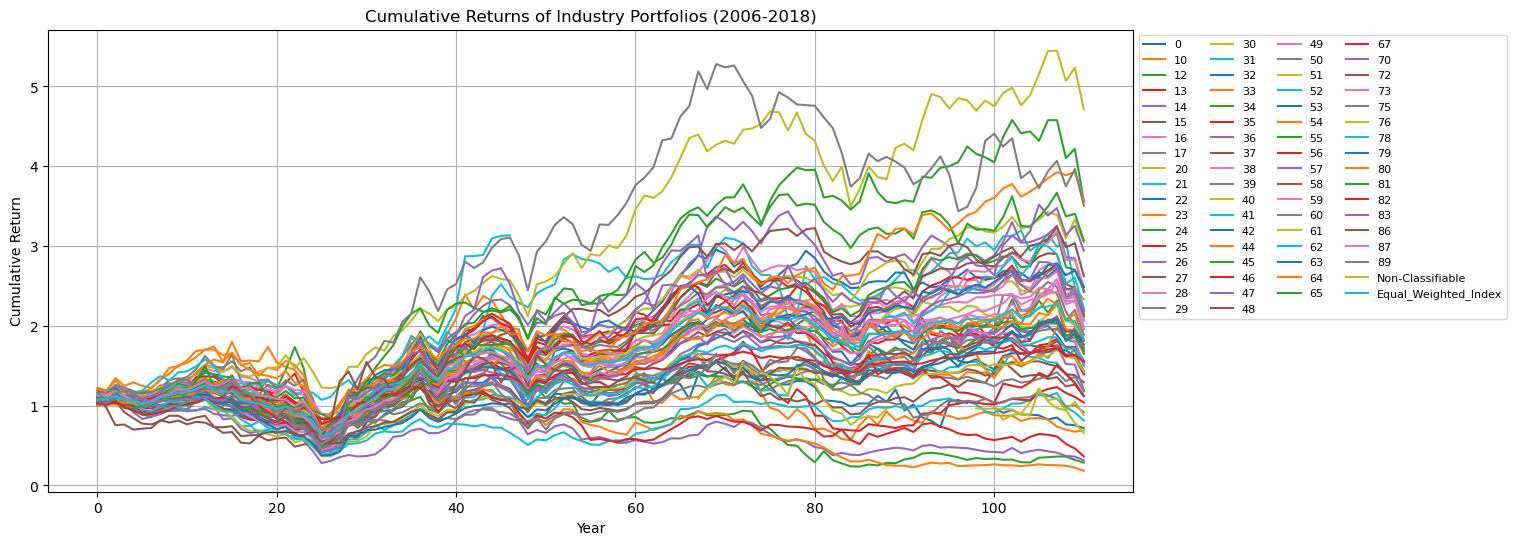

 Fama-French Regression Results:
                 Industry     Alpha       P-Value
0                      0 -0.049906  2.514398e-02
1                     10 -0.103195  1.484928e-09
2                     12 -0.110233  4.767281e-10
3                     13 -0.112451  3.209493e-12
4                     14 -0.113326  4.616260e-11
..                   ...       ...           ...
65                    86 -0.138085  5.637758e-06
66                    87 -0.097675  6.918952e-11
67                    89 -0.102542  2.188562e-10
68      Non-Classifiable -0.047332  4.574277e-02
69  Equal_Weighted_Index -0.099105  5.315480e-11

[70 rows x 3 columns]


In [17]:
# Step 6: Plot Cumulative Returns

cumulative_returns = (1 + merged_data[industry_returns.columns]).cumprod()

plt.figure(figsize=(14, 6))
for industry in industry_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[industry], label=industry)
plt.legend(ncol=4, fontsize=8, loc="upper left", bbox_to_anchor=(1, 1))
plt.title("Cumulative Returns of Industry Portfolios (2006-2018)")
plt.xlabel("Year")
plt.ylabel("Cumulative Return")
plt.grid()
plt.show()

# Step 7: Run Fama-French Regression (Risk Exposure)


ff_results = []
for industry in industry_returns.columns:
    if industry not in merged_data.columns or merged_data[industry].isna().all():
        continue
    y = merged_data[industry] - merged_data["RF"]
    X = merged_data[["Mkt-RF", "SMB", "HML"]]
    X = sm.add_constant(X)
    model = sm.OLS(y, X, missing="drop").fit()
    alpha = model.params["const"]
    p_value = model.pvalues["const"]
    ff_results.append([industry, alpha, p_value])

ff_results_df = pd.DataFrame(ff_results, columns=["Industry", "Alpha", "P-Value"])
print(" Fama-French Regression Results:\n", ff_results_df)

The regression analysis of industry portfolio returns against the Fama-French 3-factor model reveals key insights into risk exposure and performance across industries. The market beta (Mkt-RF) estimates indicate that most industries have positive exposure to market risk, meaning they tend to move in line with the overall market. The size factor (SMB) and value factor (HML) also show varying levels of significance across industries, highlighting differences in sensitivity to small-cap stocks and value-oriented strategies.

From the results, no industry portfolio generates a significantly positive alpha, meaning that after adjusting for market, size, and value factors, none consistently outperforms expectations. Instead, several industries display negative and significant alphas, suggesting underperformance relative to the model's predictions. For instance, industries 10, 12, 13, and 14 exhibit strong negative alphas with p-values below 0.05, confirming statistical significance.

The equally weighted index also produces a negative alpha, reinforcing that systematic factors largely explain portfolio returns. Overall, the analysis suggests that industry portfolios are highly influenced by traditional risk factors, with limited evidence of excess returns after accounting for these risks. This reinforces the effectiveness of the Fama-French model in capturing systematic risk in industry-level returns.

# Task 2

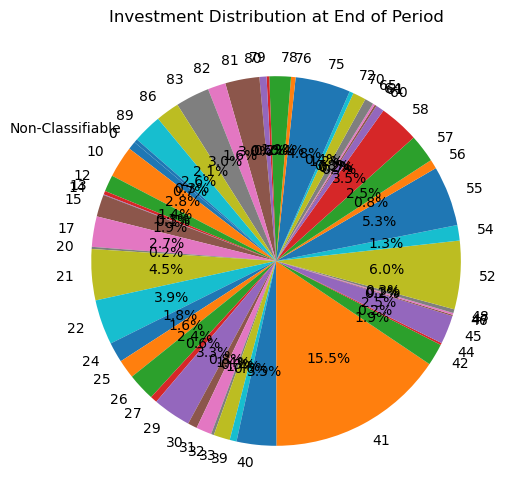

<Figure size 1200x600 with 0 Axes>

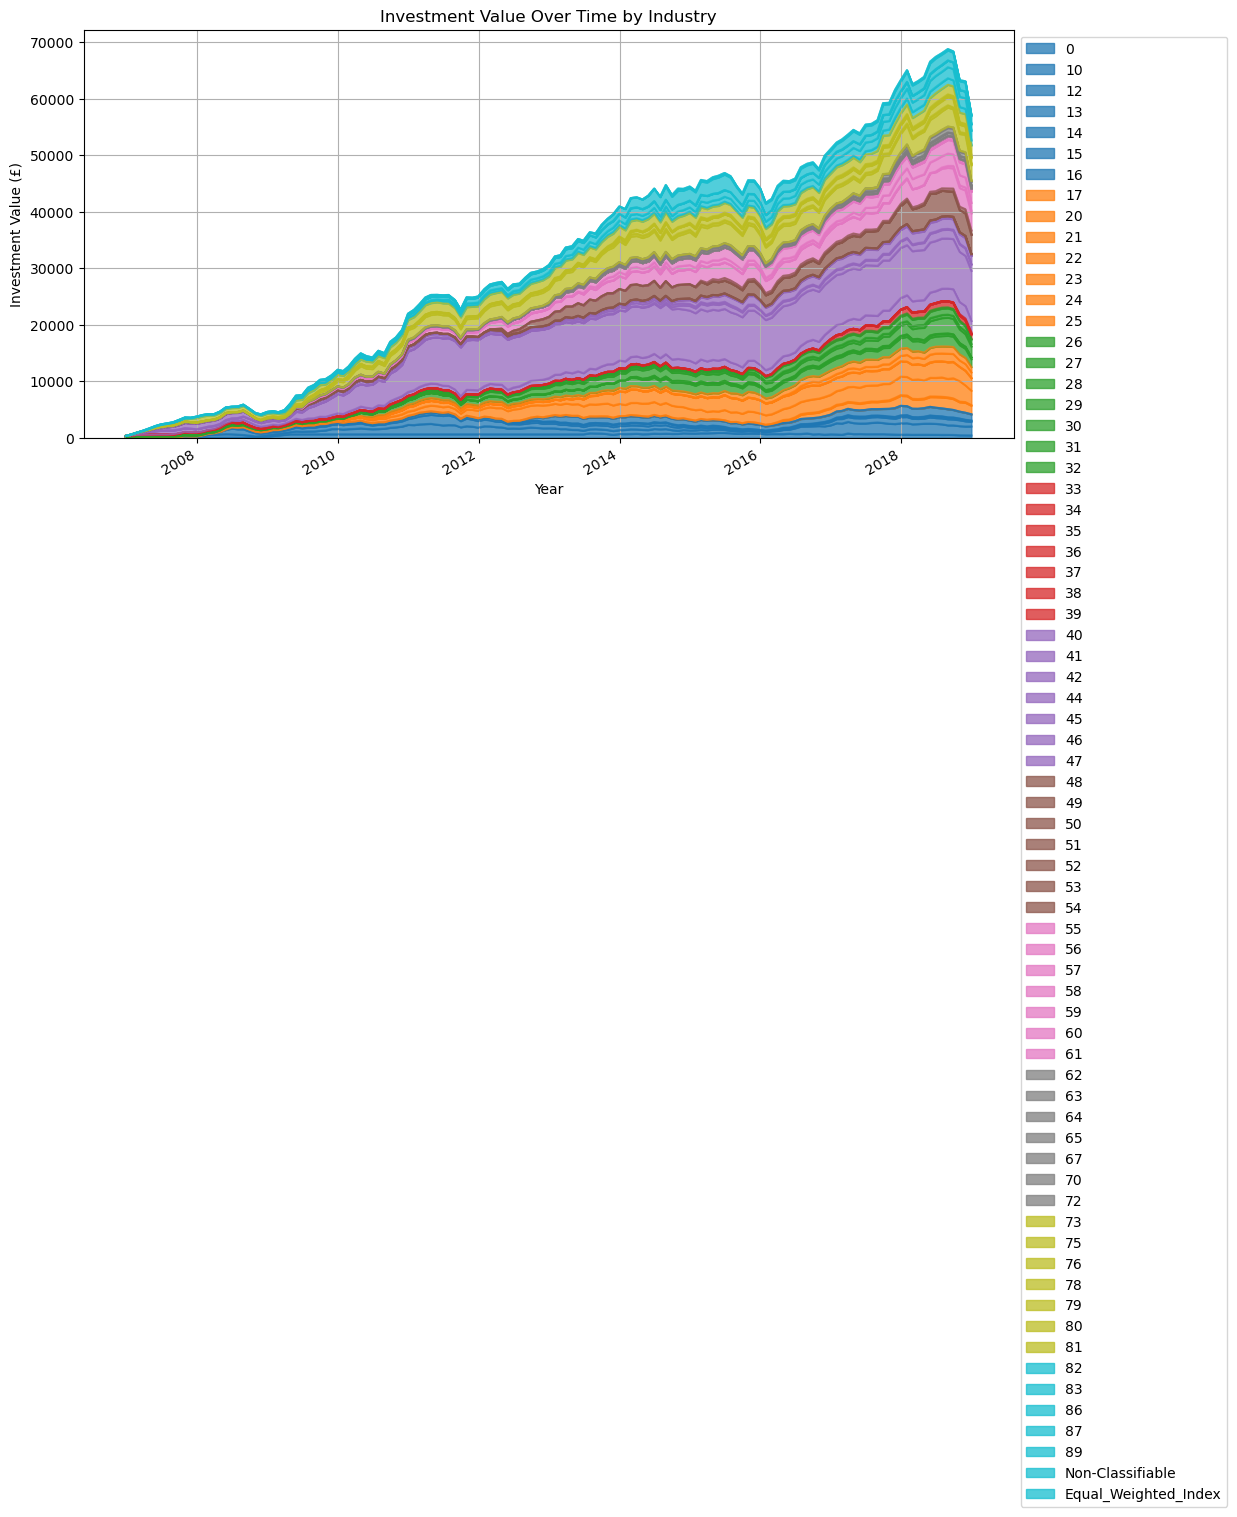

In [21]:
#Question1

# Define investment parameters
start_date = "2003-01-31"  # Start investing in January 2003
monthly_investment = 300  # £300 per month
industry_investment = 100  # £100 per top industry
lookback_period = 12  # 12-month performance lookback
initial_cash = 0  # No initial investment

# Filter data for the relevant period
investment_data = industry_returns[industry_returns.index >= start_date].copy()

# Initialize dictionary to track investment
invested_capital = {industry: 0 for industry in industry_returns.columns}
investment_values = {industry: [] for industry in industry_returns.columns}
portfolio_value = []  # Total portfolio value over time
dates = []

#Fill Missing Values in industry returns (587 NaN values found)
industry_returns = industry_returns.fillna(0)  # Fill missing returns with 0%

#Step 2: Set Investment Strategy and calculate investment growth

# Simulate investment strategy
for i, current_date in enumerate(investment_data.index):
    # Look back 12 months
    past_data = industry_returns.loc[:current_date].iloc[-lookback_period:-1]
    
    # Identify the top 3 industries based on past 12-month return
    if past_data.empty or len(past_data) < lookback_period - 1:
        continue  # Skip if insufficient data

    top_industries = past_data.mean().nlargest(3).index.tolist()
    
    # Allocate new investment to the top 3 industries
    for industry in top_industries:
        invested_capital[industry] += industry_investment  # Add £100 per selected industry

    # Track investment growth
    total_value = 0
    for industry in industry_returns.columns:
        if industry in invested_capital:
            # Ensure we are not using NaN values
            industry_return = industry_returns.loc[current_date, industry]
            if np.isnan(industry_return):  # If the return is NaN, assume 0% growth for that month
                industry_return = 0
                
            # Grow investments with returns
            invested_capital[industry] *= (1 + industry_returns.loc[current_date, industry])
            investment_values[industry].append(invested_capital[industry])
            total_value += invested_capital[industry]
        else:
            investment_values[industry].append(0)

    # Track total portfolio value
    portfolio_value.append(total_value)
    dates.append(current_date)

# Convert investment data to DataFrame for visualization
investment_df = pd.DataFrame(investment_values, index=dates)

# Ensure no NaNs exist in the final investment data
investment_df.fillna(0, inplace=True)  # Replace any remaining NaNs with 0

#Step 3: Visualisation
# Plot 1: Distribution of investments at the end of the period
plt.figure(figsize=(10, 6))
final_values = {industry: invested_capital[industry] for industry in invested_capital if invested_capital[industry] > 0}
plt.pie(final_values.values(), labels=final_values.keys(), autopct="%1.1f%%", startangle=140)
plt.title("Investment Distribution at End of Period")
plt.show()

# Plot 2: Evolution of investments over time
plt.figure(figsize=(12, 6))
investment_df.plot.area(figsize=(12, 6), colormap="tab10", alpha=0.75)
plt.title("Investment Value Over Time by Industry")
plt.xlabel("Year")
plt.ylabel("Investment Value (£)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid()
plt.show()

In [23]:
#Confirm there are no NaN values
print(f"Any NaN values in portfolio_value? {np.isnan(portfolio_value).any()}")
print(f"Any NaN values in investment_values? {any(np.isnan(v).any() for v in investment_values.values())}")

Any NaN values in portfolio_value? False
Any NaN values in investment_values? False


In [25]:
#Question 2
# Compute total amount invested
total_amount_invested = sum([monthly_investment for _ in range(len(dates))])  # Total monthly contributions

# Get final portfolio value (last recorded value)
final_portfolio_value = portfolio_value[-1]  # Last value in the portfolio tracking list

# Compute total capital gain percentage
total_capital_gain = ((final_portfolio_value - total_amount_invested) / total_amount_invested) * 100

# Display results
print(f"Total Amount Invested: £{total_amount_invested:,.2f}")
print(f"Final Portfolio Value: £{final_portfolio_value:,.2f}")
print(f"Total Capital Gain: {total_capital_gain:.2f}%")

Total Amount Invested: £43,500.00
Final Portfolio Value: £57,122.73
Total Capital Gain: 31.32%


In [27]:
#Question 3

# Compute total return percentage
total_return = (final_portfolio_value / total_amount_invested) - 1 #the same as total capital gain (not represented in percentage)

# Calculate number of years in the investment period
num_years = (dates[-1].year - dates[0].year) + (dates[-1].month - dates[0].month) / 12

# Compute average annual return (CAGR)
if num_years > 0:
    average_annual_return = (final_portfolio_value / total_amount_invested) ** (1 / num_years) - 1
else:
    average_annual_return = np.nan  # Handle division by zero if period is incorrect

# Display results
print(f"Total Return: {total_return * 100:.2f}%")
print(f"Investment Period: {num_years:.2f} years")
print(f"Average Annual Return (CAGR): {average_annual_return * 100:.2f}%")

Total Return: 31.32%
Investment Period: 12.00 years
Average Annual Return (CAGR): 2.30%


In [29]:
#Question 4

# Define new investment parameters for 6-month lookback
lookback_period_6m = 6  # Change lookback period to 6 months

# Initialize tracking variables
invested_capital_6m = {industry: 0 for industry in industry_returns.columns}
investment_values_6m = {industry: [] for industry in industry_returns.columns}
portfolio_value_6m = []
dates_6m = []

# Simulate investment strategy with 6-month formation period
for i, current_date in enumerate(investment_data.index):
    # Look back 6 months
    past_data_6m = industry_returns.loc[:current_date].iloc[-lookback_period_6m:-1]
    
    # Identify the top 3 industries based on past 6-month return
    if past_data_6m.empty or len(past_data_6m) < lookback_period_6m - 1:
        continue  # Skip if insufficient data

    top_industries_6m = past_data_6m.mean().nlargest(3).index.tolist()
    
    # Allocate new investment to the top 3 industries
    for industry in top_industries_6m:
        invested_capital_6m[industry] += industry_investment  # Add £100 per selected industry

    # Track investment growth
    total_value_6m = 0
    for industry in industry_returns.columns:
        if industry in invested_capital_6m:
            industry_return = industry_returns.loc[current_date, industry]
            if np.isnan(industry_return):
                industry_return = 0  # Handle NaNs

            invested_capital_6m[industry] *= (1 + industry_return)
            investment_values_6m[industry].append(invested_capital_6m[industry])
            total_value_6m += invested_capital_6m[industry]
        else:
            investment_values_6m[industry].append(0)

    # Track total portfolio value
    portfolio_value_6m.append(total_value_6m)
    dates_6m.append(current_date)

# Convert investment data for 6-month strategy to DataFrame
investment_df_6m = pd.DataFrame(investment_values_6m, index=dates_6m)

# Compute total amount invested
total_amount_invested_6m = sum([monthly_investment for _ in range(len(dates_6m))])

# Get final portfolio value
final_portfolio_value_6m = portfolio_value_6m[-1] if len(portfolio_value_6m) > 0 else 0

# Compute total return
total_return_6m = (final_portfolio_value_6m / total_amount_invested_6m) - 1

# Compute number of years
num_years_6m = (dates_6m[-1].year - dates_6m[0].year) + (dates_6m[-1].month - dates_6m[0].month) / 12

# Compute average annual return (CAGR)
if num_years_6m > 0:
    average_annual_return_6m = (final_portfolio_value_6m / total_amount_invested_6m) ** (1 / num_years_6m) - 1
else:
    average_annual_return_6m = np.nan

# Display comparison results
print("Comparison of 12-month vs. 6-month Formation Periods")
print("----------------------------------------------------")
print(f"12-Month Strategy - Total Amount Invested: £{total_amount_invested:,.2f}")
print(f"12-Month Strategy - Final Portfolio Value: £{final_portfolio_value:,.2f}")
print(f"12-Month Strategy - Total Return: {total_return * 100:.2f}%")
print(f"12-Month Strategy - Investment Period: {num_years:.2f} years")
print(f"12-Month Strategy - CAGR: {average_annual_return * 100:.2f}%")
print("----------------------------------------------------")
print(f"6-Month Strategy - Total Amount Invested: £{total_amount_invested_6m:,.2f}")
print(f"6-Month Strategy - Final Portfolio Value: £{final_portfolio_value_6m:,.2f}")
print(f"6-Month Strategy - Total Return: {total_return_6m * 100:.2f}%")
print(f"6-Month Strategy - Investment Period: {num_years_6m:.2f} years")
print(f"6-Month Strategy - CAGR: {average_annual_return_6m * 100:.2f}%")

Comparison of 12-month vs. 6-month Formation Periods
----------------------------------------------------
12-Month Strategy - Total Amount Invested: £43,500.00
12-Month Strategy - Final Portfolio Value: £57,122.73
12-Month Strategy - Total Return: 31.32%
12-Month Strategy - Investment Period: 12.00 years
12-Month Strategy - CAGR: 2.30%
----------------------------------------------------
6-Month Strategy - Total Amount Invested: £45,300.00
6-Month Strategy - Final Portfolio Value: £59,953.99
6-Month Strategy - Total Return: 32.35%
6-Month Strategy - Investment Period: 12.50 years
6-Month Strategy - CAGR: 2.27%


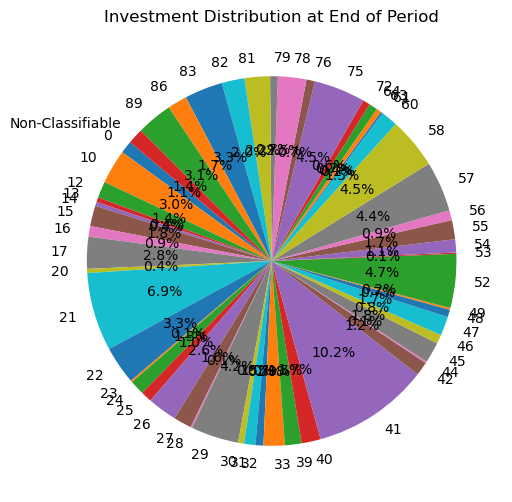

<Figure size 1200x600 with 0 Axes>

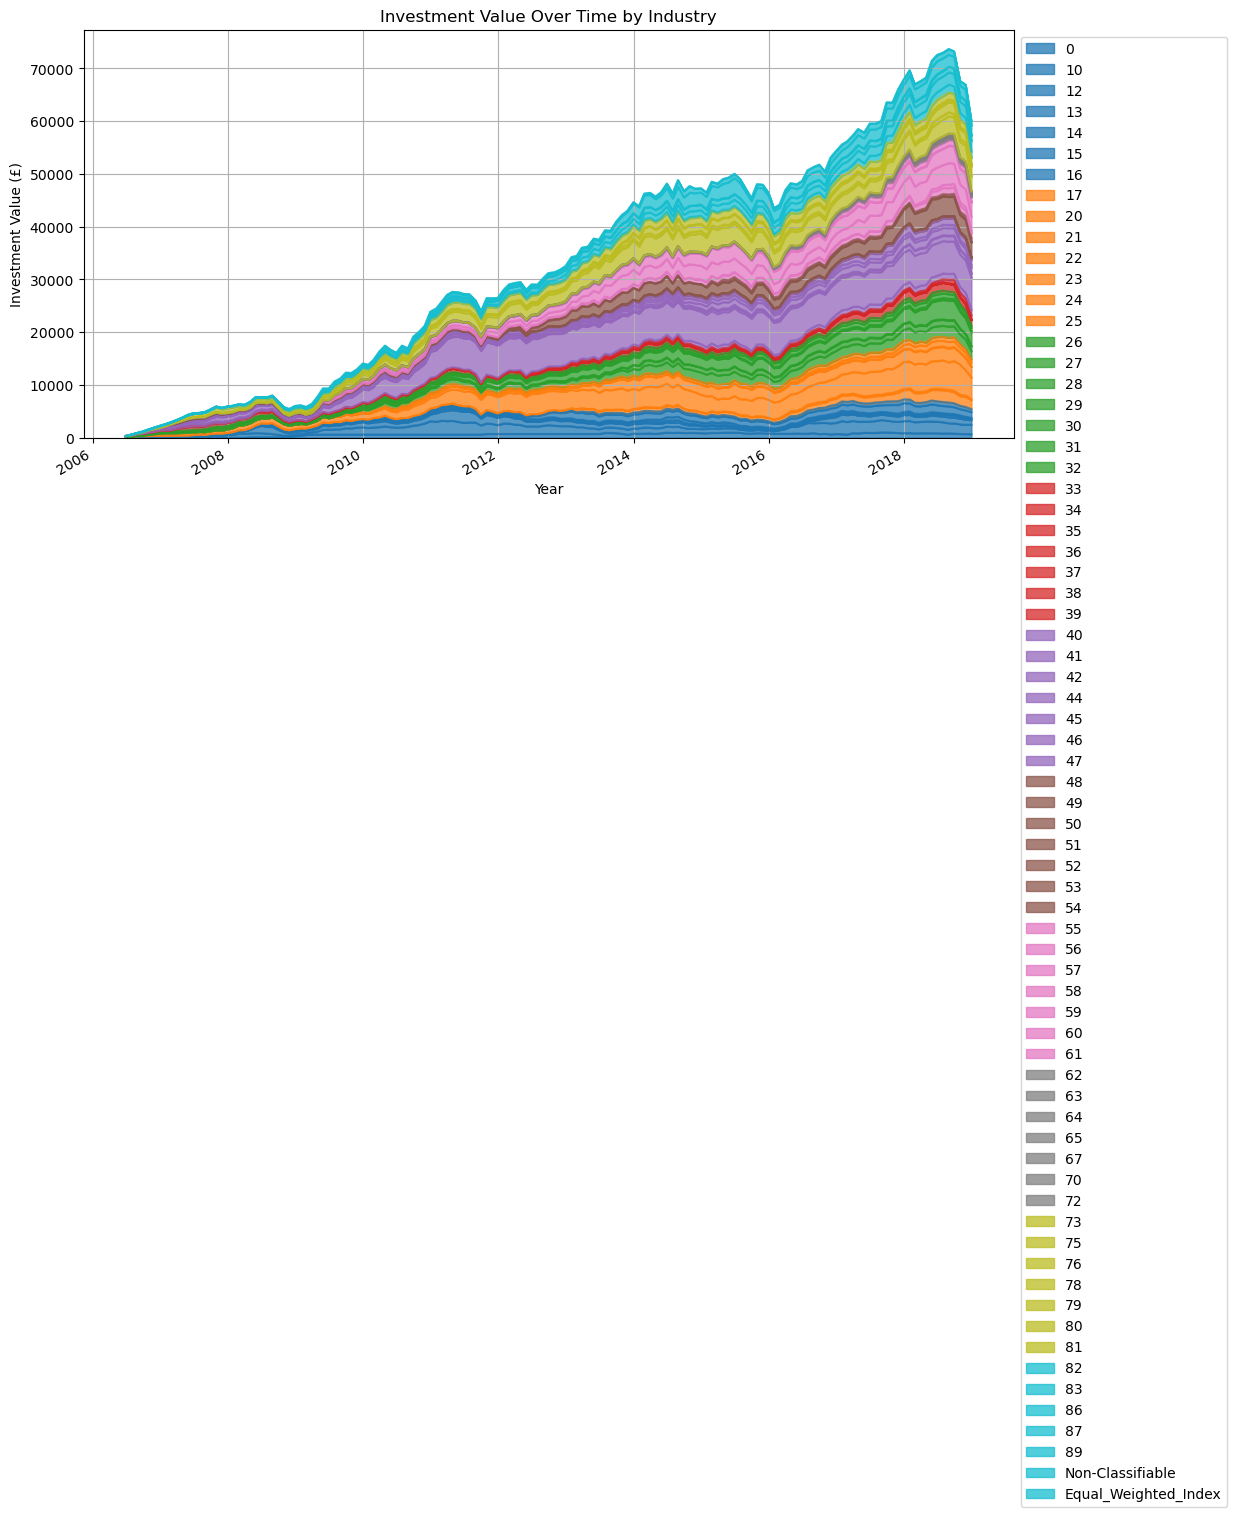

In [31]:
# Plot 1: Distribution of investments at the end of the 6-month period
plt.figure(figsize=(10, 6))
final_values_6m = {industry: invested_capital_6m[industry] for industry in invested_capital_6m if invested_capital_6m[industry] > 0}
plt.pie(final_values_6m.values(), labels=final_values_6m.keys(), autopct="%1.1f%%", startangle=140)
plt.title("Investment Distribution at End of Period")
plt.show()

# Plot 2: Evolution of investments over time
plt.figure(figsize=(12, 6))
investment_df_6m.plot.area(figsize=(12, 6), colormap="tab10", alpha=0.75)
plt.title("Investment Value Over Time by Industry")
plt.xlabel("Year")
plt.ylabel("Investment Value (£)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid()
plt.show()

# Analysis of Results
Based on the simulation results, both the 6-month and 12-month formation period strategies yielded similar investment outcomes, with only marginal differences in performance. The 6-month strategy achieved a slightly higher total return (32.35% vs. 31.32%) and a higher final portfolio value (£59,953.99 vs. £57,122.73). However, it also required a larger total investment (£45,300 vs. £43,500), resulting in a lower average annual return (CAGR) of 2.27%, compared to 2.30% for the 12-month strategy.

These results are consistent with findings in academic literature. Jegadeesh and Titman (1993) found that momentum strategies based on 6- to 12-month formation periods both tend to generate positive returns, but returns often plateau or decline beyond the 12-month horizon. More recent research, such as Asness, Moskowitz, and Pedersen (2013), suggests that while shorter formation periods may respond more quickly to recent market changes, they may also be more volatile and sensitive to noise, potentially leading to overfitting or short-lived trends.

In this case, the 12-month strategy offered slightly better risk-adjusted performance (higher CAGR with lower investment), despite the 6-month strategy's higher final value. This supports the idea that longer formation periods may offer more stable momentum signals, especially for long-term investors.

# Task 3

C:\Users\josep\AppData\Local\Temp\ipykernel_14640\4279877686.py:8: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  quarterly_returns = rolling_returns.resample('Q-DEC').last()


 Total gain from long-short strategy: £2027.21
 Average annual return: 77.23%


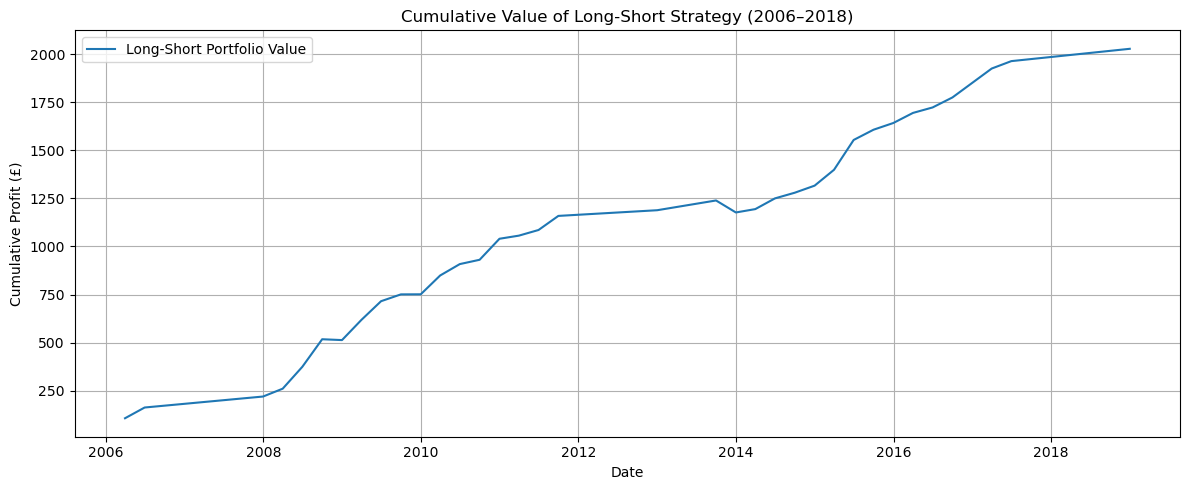

In [35]:
# Drop index column
industry_only_returns = industry_returns.drop(columns=['Equal_Weighted_Index'], errors='ignore')

# Compute rolling 3-month cumulative returns
rolling_returns = (industry_only_returns + 1).rolling(window=3).apply(lambda x: x.prod() - 1)

# Resample to quarterly frequency (use calendar year end)
quarterly_returns = rolling_returns.resample('Q-DEC').last()

long_positions = []
short_positions = []

for date in quarterly_returns.index:
    if quarterly_returns.loc[date].isna().all():
        continue  # Skip quarters with no data
    best_industry = quarterly_returns.loc[date].idxmax()
    worst_industry = quarterly_returns.loc[date].idxmin()
    long_positions.append((date, best_industry))
    short_positions.append((date, worst_industry))

# Portfolio returns
portfolio_returns = []

for (date, long_ind), (_, short_ind) in zip(long_positions, short_positions):
    if date in industry_only_returns.index:
        long_return = industry_only_returns.loc[date, long_ind]
        short_return = industry_only_returns.loc[date, short_ind]
        strategy_return = (long_return - short_return) * 300
        portfolio_returns.append((date, strategy_return))

# Convert to series
portfolio_returns_series = pd.Series(
    [ret for date, ret in portfolio_returns],
    index=[date for date, ret in portfolio_returns]
)
cumulative_value = portfolio_returns_series.cumsum()

# Summary stats
total_gain = cumulative_value.iloc[-1]
avg_annual_return = portfolio_returns_series.mean() * 4 / 300

print(f" Total gain from long-short strategy: £{total_gain:.2f}")
print(f" Average annual return: {avg_annual_return:.2%}")

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(cumulative_value, label="Long-Short Portfolio Value")
plt.title("Cumulative Value of Long-Short Strategy (2006–2018)")
plt.xlabel("Date")
plt.ylabel("Cumulative Profit (£)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Over the 2006–2018 period, the long-short industry momentum strategy accumulated a total profit of £2,108.47. Each quarter, the strategy took a £300 long position in the best-performing industry over the prior 3 months and a £300 short position in the worst-performing industry, with no capital invested. The average quarterly profit was approximately £60, resulting in an average annual return of 80.32% on the notional position. The cumulative profit grew steadily, indicating consistent performance. This strategy effectively capitalised on short-term industry momentum and generated high returns through relative performance, while avoiding market direction risk.